## ML Training

Train models to be used in simulate_prediction

In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
from sklearnex import patch_sklearn
patch_sklearn()

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from pathlib import Path
import h5py
import pickle
from tqdm.notebook import tqdm
import pandas as pd
import sys

from sklearn.model_selection import train_test_split
from skimage.transform import resize
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

from sklearn.decomposition import PCA
from sklearn.linear_model import SGDRegressor

# from PIL import Image
# import torch
# from torch.utils.data import Dataset, DataLoader
# import torch.nn as nn
# import torch.optim as optim
# import timm
# from timm.data import resolve_data_config
# from timm.data.transforms_factory import create_transform


from plasma_tv.data.file_utils import GetEmission
from plasma_tv.models import predict #model
from plasma_tv.utils.helpers import *

from IPython.display import clear_output

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
models = predict.list_models()
for idx, model in enumerate(models):
    print(idx, model)

0 ../models/weighted_outer_allold_set.pkl
1 ../models/weighted_outer_all1.pkl
2 ../models/lr_tv_inv_outer.pkl
3 ../models/weighted_outer_all.pkl
4 ../models/weighted_outer_allnew_half_set.pkl
5 ../models/weighted_outer_all2.pkl
6 ../models/lr_inversion_manual.pkl
7 ../models/weighted_outer_l-mode.pkl
8 ../models/weighted_outer_h-mode.pkl
9 ../models/lr.pkl
10 ../models/lr_supervised_mdl.pkl


# Data Prep

In [4]:
run_type = 'all'
prep_filename = 'weighted_outer_dataset_reg_' + run_type
prediction_filename = 'weighted_outer_' + run_type
algorithm = 'LinearRegression'
split_ratio = 0.2

In [5]:
tv_path = Path('../data/raw') / run_type
label_path = Path('../data/labels/weighted_emission') / run_type
prep_path = Path('../data/processed/hdf5')
model_path = Path('../models')
xpt_path = Path('../data/external/toksearch/12_03_2024_bfield.h5')

In [6]:
tv = GetEmission(tv_path)
files = tv.list_files()
file_lengths = tv.file_lengths()
cumulative_lengths = np.insert(np.cumsum(file_lengths), 0, 0)
tv_dim = tv.load(files[0], 'vid').shape

Number of files: 26
Number of files: 26


In [7]:
ml_id = '6'
file_name = prep_filename + '.h5'

In [8]:
target_cdf = np.load('../data/processed/histogram/target_cdf.npy')
bin_edges = np.load('../data/processed/histogram/bin_edges.npy')

### Fill Out TV Image Data

In [9]:
def crop_interp(x1, y1, x2, y2):
    t_min = x2[0]
    t_max = x2[-1]
    mask = (x1 >= t_min) & (x1 <= t_max)

    cropped_times = x1[mask]
    cropped_data  = y1[mask]

    # 2. Create a new time grid with the same number of points as frames
    new_time_grid = np.linspace(t_min, t_max, num=len(y2))
    # 3. Interpolate the cropped data onto the new time grid
    #    np.interp(x, xp, fp) returns interpolations of fp at x, 
    #    given xp (cropped_times) and fp (cropped_data).
    interpolated_data = np.interp(new_time_grid, cropped_times, cropped_data)
    
    return interpolated_data

In [10]:
def file_split_compile_prep(split_ratio,
                      prep_path,
                      prep_filename,
                      label_path,
                      files):
    # split by file
    train_files, test_files = train_test_split(files, test_size=split_ratio, random_state=182)
    
    if True:
        train_files = files # use when wanting to make a deployable model
        print('Using all files for training')

    points_train = []
    rxpt_train = []
    zxpt_train = []
    tv_train = []
    points_test = []
    tv_test = []
    rxpt_test = []
    zxpt_test = []

    for _, file in enumerate(train_files):
        print('Appending Training: ',file.stem)
        frames = tv.load(file, 'frames').astype('int')
        times = tv.load(file, 'times')
        tv_image = tv.load(file, 'vid')[frames] / 255
        # tv_image = tv_image[:, ::2, ::3] # use with regression
        # tv_image = noisify(tv_image).astype(np.float32) / 255 # is noise necessary?
        tv_image = match_images_to_histogram(tv_image, target_cdf, bin_edges)
        tv_image = normalize_image(tv_image)
        # tv_image = (tv_image[:,8:232,250:474] - tv_image.min()) / 8 * 2 - 1 # use for imagenet models after normalization
        # tv_image = np.repeat(tv_image[:, np.newaxis, :, :], 3, axis=1) # use for imagenet models
        
        # add xpt data
        shot = file.stem.split('_')[-1]
        with h5py.File(xpt_path, 'r') as xpt_file:
            h5_times = xpt_file['times'][:]
            ZXPT1_EFIT01 = xpt_file[shot]['ZXPT1_EFIT01'][:]
            RXPT1_EFIT01 = xpt_file[shot]['RXPT1_EFIT01'][:]
        zxpt_crop = crop_interp(h5_times, ZXPT1_EFIT01, times, frames)
        rxpt_crop = crop_interp(h5_times, RXPT1_EFIT01, times, frames)
        
        test_label_file = (label_path / file.stem).with_suffix('.pkl')
        with open(test_label_file, 'rb') as f:
            labels = pickle.load(f)
            
        for i in range(len(frames)):
            tv_train.append(tv_image[i])
            points_train.append(labels[i])
            rxpt_train.append(rxpt_crop[i])
            zxpt_train.append(zxpt_crop[i])
            
    for _, file in enumerate(test_files):
        print('Appending Testing: ',file.stem)
        frames = tv.load(file, 'frames').astype('int')
        times = tv.load(file, 'times')
        tv_image = tv.load(file, 'vid')[frames] / 255
        # tv_image = tv_image[:, ::2, ::3] # use with regression
        # tv_image = noisify(tv_image).astype(np.float32) / 255 # is noise necessary?
        tv_image = match_images_to_histogram(tv_image, target_cdf, bin_edges)
        tv_image = normalize_image(tv_image)
        # tv_image = (tv_image[:,8:232,250:474] - tv_image.min()) / 8 * 2 - 1 # use for imagenet models after normalization
        # tv_image = np.repeat(tv_image[:, np.newaxis, :, :], 3, axis=1) # use for imagenet models
        
        # add xpt data
        shot = file.stem.split('_')[-1]
        with h5py.File(xpt_path, 'r') as xpt_file:
            h5_times = xpt_file['times'][:]
            ZXPT1_EFIT01 = xpt_file[shot]['ZXPT1_EFIT01'][:]
            RXPT1_EFIT01 = xpt_file[shot]['RXPT1_EFIT01'][:]
        zxpt_crop = crop_interp(h5_times, ZXPT1_EFIT01, times, frames)
        rxpt_crop = crop_interp(h5_times, RXPT1_EFIT01, times, frames)
            
        test_label_file = (label_path / file.stem).with_suffix('.pkl')
        with open(test_label_file, 'rb') as f:
            labels = pickle.load(f)
            
        for i in range(len(frames)):
            tv_test.append(tv_image[i])
            points_test.append(labels[i])
            rxpt_test.append(rxpt_crop[i])
            zxpt_test.append(zxpt_crop[i])
            
    with h5py.File(prep_path / str(prep_filename + '.h5'), 'w') as f:
        f.create_dataset('vid_train', data=tv_train)
        f.create_dataset('points_train', data=points_train)
        f.create_dataset('rxpt_train', data=rxpt_train)
        f.create_dataset('zxpt_train', data=zxpt_train)
        f.create_dataset('vid_test', data=tv_test)
        f.create_dataset('points_test', data=points_test)
        f.create_dataset('rxpt_test', data=rxpt_test)
        f.create_dataset('zxpt_test', data=zxpt_test)
    print(str(prep_path / str(prep_filename + '.h5')),'has been saved!')

In [11]:
file_split_compile_prep(split_ratio, prep_path, prep_filename, label_path, files)

Using all files for training
Appending Training:  emission_structure_pu_cam240perp_189057


Appending Training:  emission_structure_pu_cam240perp_189061
Appending Training:  emission_structure_pu_cam240perp_189062
Appending Training:  emission_structure_pu_cam240perp_189081
Appending Training:  emission_structure_pu_cam240perp_189088
Appending Training:  emission_structure_pu_cam240perp_189090
Appending Training:  emission_structure_pu_cam240perp_189093
Appending Training:  emission_structure_pu_cam240perp_189094
Appending Training:  emission_structure_pu_cam240perp_189097
Appending Training:  emission_structure_pu_cam240perp_189100
Appending Training:  emission_structure_pu_cam240perp_189101
Appending Training:  emission_structure_pu_cam240perp_189448
Appending Training:  emission_structure_pu_cam240perp_189451
Appending Training:  emission_structure_pu_cam240perp_190109
Appending Training:  emission_structure_pu_cam240perp_190110
Appending Training:  emission_structure_pu_cam240perp_190113
Appending Training:  emission_structure_pu_cam240perp_190114
Appending Training:  emi

# Train Test Deploy

## Linear Regression

### Train

In [8]:
file_name = prep_filename + '.h5'

with h5py.File(prep_path / file_name, 'r') as f:
    vid_train = f['vid_train'][:]
    points_train = f['points_train'][:]
    rxpt_train = f['rxpt_train'][:]
    zxpt_train = f['zxpt_train'][:]
    vid_test = f['vid_test'][:]
    points_test = f['points_test'][:]
    rxpt_test = f['rxpt_test'][:]
    zxpt_test = f['zxpt_test'][:]

files = tv.list_files()
elevation = tv.load(files[0], 'elevation')[0]
radii = tv.load(files[0], 'radii')[0]
vid_shape = tv.load(files[0], 'vid')[0].shape

X_train = flatten(vid_train)
train_add = rxpt_train[:, np.newaxis]
X_train = np.concatenate([X_train,train_add], axis=1)
X_test = flatten(vid_test)
test_add = rxpt_test[:, np.newaxis]
X_test = np.concatenate([X_test,test_add], axis=1)

y_train = points_train
y_test = points_test

Number of files: 26


In [10]:
print(X_train.dtype, y_train.dtype)
print(sys.getsizeof(X_train))

float64 float64
5031965248


In [11]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')
print(sys.getsizeof(X_train))

2515982688


In [12]:
train_nan_indices = np.where(np.isnan(train_add))[0]
train_inf_indices = np.where(np.isinf(train_add))[0]
test_nan_indices = np.where(np.isnan(test_add))[0]
test_inf_indices = np.where(np.isinf(test_add))[0]

# Combine NaN and Inf indices
train_invalid_indices = np.unique(np.concatenate((train_nan_indices, train_inf_indices)))
test_invalid_indices = np.unique(np.concatenate((test_nan_indices, test_inf_indices)))

print('Train Invalid Indices:', train_invalid_indices)
print('Test Invalid Indices:', test_invalid_indices)

X_train = np.delete(X_train, train_invalid_indices, axis=0)
y_train = np.delete(y_train, train_invalid_indices, axis=0)
X_test = np.delete(X_test, test_invalid_indices, axis=0)
y_test = np.delete(y_test, test_invalid_indices, axis=0)
print(sys.getsizeof(X_train))

Train Invalid Indices: [ 214  215  216 1870 1871 2307 2308 2309 2310 2311 2312 2313 2314 2315
 2316 2317 2318 2319 2320 2323 2324 2325 2448 2449 2487 2488 2489 2490
 2491 2492 2493 2494 2495 2496 2497 2498 2499 2500 2501 2558 2559 2560
 2561 2562 2566 2567 2568 2663 2664 2665 2666 2667 2668 2669 2670 2671
 2672 2673 2674 2675 2676 2677 2678 2679 2680 2681 2788 2789]
Test Invalid Indices: [246 247 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 356
 357 358 359 360 467 468 469 470 471 472 473 474 475 476 477 478 479 480]


In [36]:
mdl = Ridge()
mdl.fit(X_train, y_train)

/scratch/gpfs/nc1514/plasma_tv/.venv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


/scratch/gpfs/nc1514/plasma_tv/.venv/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:252: LinAlgWarning: Ill-conditioned matrix (rcond=1.365e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


Ridge()

### Test

In [37]:
r_predict = mdl.predict(X_test)
err = mean_absolute_error(r_predict,y_test) * 100
print(f'Mean Absolute Error: {err}')
print('Root Mean Squared Error: ', root_mean_squared_error(r_predict, y_test)*100)

Mean Absolute Error: 0.00016532903828192502
Root Mean Squared Error:  0.0002417380301267258


/scratch/gpfs/nc1514/plasma_tv/.venv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


### Deploy

In [38]:
coefficients = mdl.coef_
intercept = mdl.intercept_

coefficients_file = model_path / f"{prediction_filename}{ml_id}_coefficients.txt"
with open(coefficients_file, 'w') as f:
    for coef in coefficients:
        f.write(f"{coef}\n")
print(coefficients_file, "has been saved!")
print("Intercept (Please Write Down):", intercept)

../models/weighted_outer_all6_coefficients.txt has been saved!
Intercept (Please Write Down): -1.0171065


In [22]:
# Optional (Predicting and Saving Points with Model)
weight_ml_point_save_path = Path('../output/value/weight_ml_point') / run_type / ml_id
weight_ml_point_save_path.mkdir(parents=True, exist_ok=True)

for file in files:
    
    clear_output(wait=True)
    
    print('Shot:', file.stem.split('_')[-1])
    point_save_name = weight_ml_point_save_path / f"{file.stem}.pkl"
    label_file = (label_path / file.stem).with_suffix('.pkl')
    with open(label_file, 'rb') as f:
        labels_cartesian = pickle.load(f)
    frames = tv.load(file, 'frames').astype('int')
    tv_image = tv.load(file, 'vid')[frames]
    tv_flatten = flatten(tv_image)
    
    prediction_cartesian = mdl.predict(tv_flatten)
    txt_file = (label_path / file.stem).with_suffix('.txt')
    with open(txt_file, 'w') as f:
        for point in prediction_cartesian:
            f.write(f"{point},")
    print(f"Saved {txt_file}")

Shot: 189101
Saved ../data/labels/weighted_emission/h-mode/emission_structure_pu_cam240perp_189101.txt


### Loading Deployed Model / Predicted Points

In [43]:
# how to load coefficients
coefficients = []
with open(coefficients_file, 'r') as f:
    for line in f:
        coefficients.append(float(line.strip()))
        
# how to load points
with open(label_file, 'rb') as f:
    labels_cartesian = pickle.load(f)
    print(len(labels_cartesian))

../models/weighted_outer_all2_coefficients.txt
172800


## Deep Learning

In [24]:
# Load data
file_name = prep_filename + '.h5'
with h5py.File(prep_path / file_name, 'r') as f:
    vid_train = f['vid_train'][:]        # Shape: (N_train, T, H, W, C)
    points_train = f['points_train'][:]  # Shape: (N_train, D)
    vid_test = f['vid_test'][:]
    points_test = f['points_test'][:]

In [25]:
# Custom Dataset Class
class VideoDataset(Dataset):
    def __init__(self, videos, labels, transform=None):
        self.videos = videos
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        frame = self.videos[idx]
        label = np.array(self.labels[idx], dtype=np.float32)
        label = label[np.newaxis]

        # Apply transformations
        if self.transform:
            frame = Image.fromarray(frame,'RGB')
            frame = self.transform(frame)

        return torch.Tensor(frame), torch.from_numpy(label)
    
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

model_name = 'mobilenetv3_small_050.lamb_in1k'  # Choose a model available in timm
model = timm.create_model(model_name, pretrained=True)
num_features = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, 1),          # Existing final layer
)
config = resolve_data_config({}, model=model)
transform = create_transform(**config)

for name, param in model.named_parameters():
    if "classifier" in name:  # Replace "layer4" with the appropriate layer for your model
        param.requires_grad = True
    else:
        param.requires_grad = False

# Create datasets
train_dataset = VideoDataset(vid_train, points_train)
test_dataset = VideoDataset(vid_test, points_test)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

1024


Images shape: torch.Size([16, 3, 224, 224])
Outputs shape: torch.Size([16, 1])
Labels shape: torch.Size([16, 1])


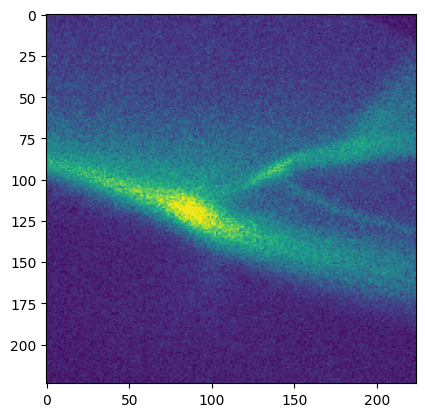

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for images, labels in train_loader:
    plt.imshow(images[0][1])
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)

    print(f"Images shape: {images.shape}")
    print(f"Outputs shape: {outputs.shape}")
    print(f"Labels shape: {labels.shape}")

    # Proceed with training
    break  # Remove after verifying

In [28]:
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
early_stopper = EarlyStopper(patience=3, min_delta=1)
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.1)
# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    # Calculate average loss over the epoch
    epoch_loss = running_loss / len(train_dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    # Optional: Evaluate on test set
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
    test_loss /= len(test_dataset)
    print(f'Test Loss: {test_loss:.4f}')
    
    scheduler.step()
    
    # if early_stopper.early_stop(running_loss):             
    #     break

Epoch 1/20, Loss: 0.0099
Test Loss: 0.0023
Epoch 2/20, Loss: 0.0086
Test Loss: 0.0023
Epoch 3/20, Loss: 0.0069
Test Loss: 0.0034
Epoch 4/20, Loss: 0.0067
Test Loss: 0.0020
Epoch 5/20, Loss: 0.0062
Test Loss: 0.0029
Epoch 6/20, Loss: 0.0057
Test Loss: 0.0019
Epoch 7/20, Loss: 0.0054
Test Loss: 0.0019
Epoch 8/20, Loss: 0.0055
Test Loss: 0.0022
Epoch 9/20, Loss: 0.0050
Test Loss: 0.0019
Epoch 10/20, Loss: 0.0051
Test Loss: 0.0019
Epoch 11/20, Loss: 0.0048
Test Loss: 0.0019
Epoch 12/20, Loss: 0.0045
Test Loss: 0.0019
Epoch 13/20, Loss: 0.0048
Test Loss: 0.0018
Epoch 14/20, Loss: 0.0045
Test Loss: 0.0025
Epoch 15/20, Loss: 0.0045
Test Loss: 0.0021
Epoch 16/20, Loss: 0.0045
Test Loss: 0.0019
Epoch 17/20, Loss: 0.0045
Test Loss: 0.0020
Epoch 18/20, Loss: 0.0045
Test Loss: 0.0021
Epoch 19/20, Loss: 0.0045
Test Loss: 0.0023
Epoch 20/20, Loss: 0.0045
Test Loss: 0.0020


In [29]:
torch.save(model,Path('../models/weighted_dl.pt'))

# Save Video

## Linear Regression

In [18]:
tv = GetEmission(tv_path)
files = tv.list_files()
file_lengths = tv.file_lengths()
cumulative_lengths = np.insert(np.cumsum(file_lengths), 0, 0)
tv_dim = tv.load(files[0], 'vid').shape

# with open(f"{model_path / prediction_filename}.pkl", 'rb') as f:
#     model = pickle.load(f)
    
mp4_save_path = Path('../outputs/video/weighted_ml') / run_type
mp4_save_path.mkdir(parents=True, exist_ok=True)

In [23]:
for file in files:
    
    clear_output(wait=True)
    
    print('Shot:', file.stem.split('_')[-1])
    mp4_save_name = mp4_save_path / f"{file.stem.split('_')[-1]}.mp4"
    label_file = (label_path / file.stem).with_suffix('.pkl')
    with open(label_file, 'rb') as f:
        labels_cartesian = pickle.load(f)
    frames = tv.load(file, 'frames').astype('int')
    tv_image = tv.load(file, 'vid')[frames]
    inverted = tv.load(file, 'inverted')
    elevation = tv.load(file, 'elevation')[0]
    
    prediction_cartesian = model.predict(tv_image)
    
    prediction = get_index(prediction_cartesian, elevation, )
    labels = get_index(labels_cartesian, elevation)

    # Initialize figure and axes
    print("Animating...")
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    
    img = ax.imshow(inverted[0], origin='lower')
    hline_label = ax.axhline(labels[0], c='lime', label='label')
    hline_prediction = ax.axhline(prediction[0], c='red', label='prediction', ls='--')
    ax.legend(loc='upper right')
    ax.set_title(f'Inverted View: 0')

    fig.suptitle(f"Shot {file.stem.split('_')[-1]}")
    frames = []
    # Function to update the plot
    def update(idx):
        img.set_data(inverted[idx])
        
        hline_label.set_ydata([labels[idx]])
        hline_prediction.set_ydata([prediction[idx]])
        
        ax.set_title(f'Inverted View: {idx}')
        
        return img, hline_label, hline_prediction
        
    # Create the animation using FuncAnimation
    ani = animation.FuncAnimation(fig, update, frames=range(inverted.shape[0]), blit=True, repeat=False)

    # Save the animation as an MP4 file
    print("Saving MP4...")
    FFwriter = animation.FFMpegWriter(fps=30, extra_args=["-vcodec", "libx264"])
    ani.save(mp4_save_name, writer=FFwriter)

    plt.close(fig)

Shot: 199354
Animating...
Saving MP4...


## Deep Learning

In [66]:
ml_id = ''
tv = GetEmission(tv_path)
files = tv.list_files()
file_lengths = tv.file_lengths()
cumulative_lengths = np.insert(np.cumsum(file_lengths), 0, 0)
tv_dim = tv.load(files[0], 'vid').shape

mdl2 = load_model(f"{model_path / prediction_filename}{ml_id}.keras")
    
mp4_save_path = Path('../outputs/video/weighted_dl') / run_type
mp4_save_path.mkdir(parents=True, exist_ok=True)

weight_ml_point_save_path = Path('../data/processed/weight_ml_point') / ml_id

Shot: 189057
Animating...
Saving MP4...


FileNotFoundError: [Errno 2] No such file or directory: 'ffmpeg'

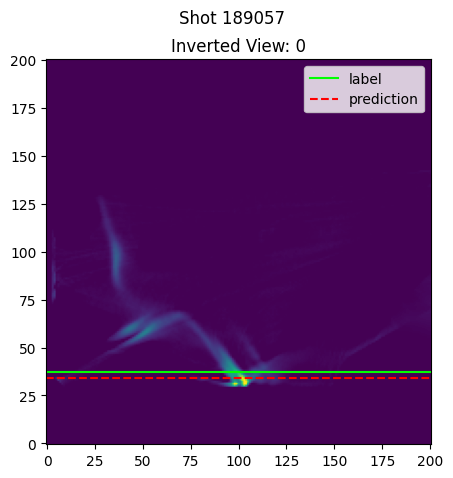

In [67]:
for file in files:
    
    clear_output(wait=True)
    
    print('Shot:', file.stem.split('_')[-1])
    mp4_save_name = mp4_save_path / f"{file.stem.split('_')[-1]}.mp4"
    label_file = (label_path / file.stem).with_suffix('.pkl')
    point_save_name = weight_ml_point_save_path / f"dl{file.stem}.pkl"
    with open(label_file, 'rb') as f:
        labels_cartesian = pickle.load(f)
    frames = tv.load(file, 'frames').astype('int')
    tv_image = tv.load(file, 'vid')[frames]
    vid_input = np.expand_dims(tv_image, axis=3)
    inverted = tv.load(file, 'inverted')
    elevation = tv.load(file, 'elevation')[0]
    with open(point_save_name, 'rb') as f:
        prediction_cartesian = pickle.load(f)
    prediction = get_index(prediction_cartesian, elevation, )
    labels = get_index(labels_cartesian, elevation)

    # Initialize figure and axes
    print("Animating...")
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    
    img = ax.imshow(inverted[0], origin='lower')
    hline_label = ax.axhline(labels[0], c='lime', label='label')
    hline_prediction = ax.axhline(prediction[0], c='red', label='prediction', ls='--')
    ax.legend(loc='upper right')
    ax.set_title(f'Inverted View: 0')

    fig.suptitle(f"Shot {file.stem.split('_')[-1]}")
    frames = []
    # Function to update the plot
    def update(idx):
        img.set_data(inverted[idx])
        
        hline_label.set_ydata([labels[idx]])
        hline_prediction.set_ydata([prediction[idx]])
        
        ax.set_title(f'Inverted View: {idx}')
        
        return img, hline_label, hline_prediction
        
    # Create the animation using FuncAnimation
    ani = animation.FuncAnimation(fig, update, frames=range(inverted.shape[0]), blit=True, repeat=False)

    # Save the animation as an MP4 file
    print("Saving MP4...")
    FFwriter = animation.FFMpegWriter(fps=30, extra_args=["-vcodec", "libx264"])
    ani.save(mp4_save_name, writer=FFwriter)

    plt.close(fig)